In [18]:
import sys
from pathlib import Path

# Add parent directory to Python path
parent_dir = Path().resolve().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

import torch
import scanpy as sc
import anndata as ad
import celldiffusion as cd

import os
import csv


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
if device == 'cuda':
    print(torch.cuda.get_device_name())

cuda
NVIDIA L40S


In [24]:
# Use paths relative to the project root (parent directory of this notebook)

dataset = "PBMC10K"



DATA_PATH = '/projectnb/czlab/A00/ycliu/scRNA_integration_benchmark_datasets/PBMC10K/'

OUTPUT_PATH = str(parent_dir / 'data' / 'outputs'/ 'stress_tests_pbmc10k') + '/'


# Load dataset

In [4]:
adata = sc.read_h5ad(DATA_PATH + 'pbmc10k.h5ad')

adata

AnnData object with n_obs × n_vars = 11990 × 3346
    obs: 'batch', 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types'

# Preprocess

/usr2/postdoc/ycliu137/.conda/envs/private_celldiffusion_env/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:88: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  return fn(*args_all, **kw)


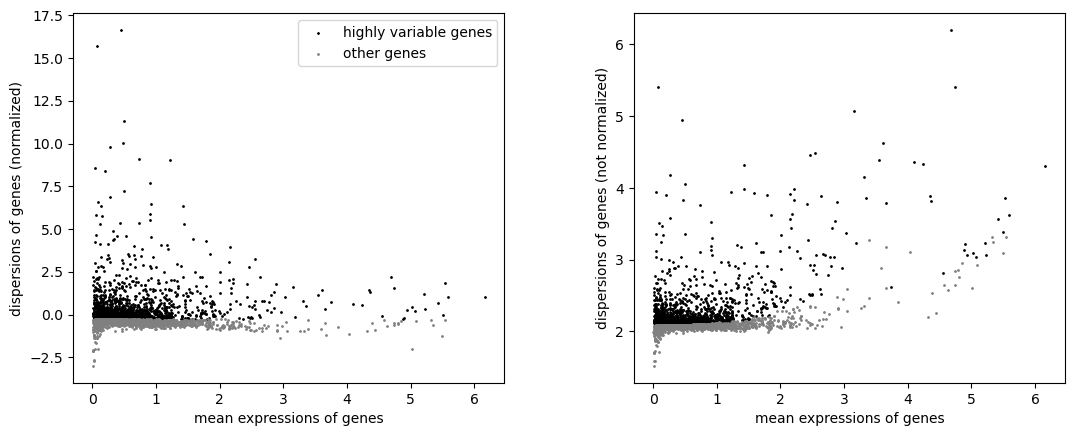

In [5]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [6]:
adata.raw = adata.copy()
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 11990 × 2000
    obs: 'batch', 'labels'
    var: 'gene_ids', 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

# Feature encoder

In [7]:
cd.encode_features(adata, 
                   D_encode_list=[2000, 300, 50], # Encoder dimension in each layer
                   D_decode_list=[50, 300, 2000], # Decoder dimension in each layer
                   max_epoch=2000, # number of epoch
                   lr=1e-3,        # learning rate
                   device=device)


2025-12-21 15:54:58,093 - --------> Starting feature encoder ...
/projectnb/czproj/Algorithms/ycliu/Private_CellDiffusion/diffusion/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)
2025-12-21 15:55:00,180 - ------------------------> Epoch: 1/2000, Current loss: 20353436.0000
2025-12-21 15:55:01,148 - ------------------------> Epoch: 51/2000, Current loss: 8560964.0000
2025-12-21 15:55:02,067 - ------------------------> Epoch: 101/2000, Current loss: 8264619.0000
2025-12-21 15:55:02,979 - ------------------------> Epoch: 151/2000, Current loss: 8041509.0000
2025-12-21 15:55:03,892 - ------------------------> Epoch: 201/2000, Current loss: 7864069.5000
2025-12-21 15:55:04,802 - ------------------------> Epoch: 251/2000, Current los

# Integration

In [55]:
# Build the input KNN adjacencies for each batch, which is used in loss function.

cd.inte.build_integration_loss_adj(adata, 
                                   use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                                   k=50,            # K for building KNN graph
                                   device=device)

In [37]:
# Build the diffusion graph for data intagration

cd.inte.build_integration_graph(adata, 
                            batch_key='batch', # get batch labels
                            use_rep='X_fae',   # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                            n_edges_per_node=50, # Number of outgoing edges of each node in the diffusion graph.
                            k_mnn=50,      # K for KNNs that toward finding MNNs.
                            device=device)

In [38]:
print(adata.uns['integration_edge_index'].shape)
print("Neighbor purity: ", cd.eval.evaluate_neighbor_purity(adata, label_key='labels', graph_key='integration_edge_index'))


(2, 599500)
Neighbor purity:  0.9334762301918266


In [119]:
k_added = 70

cd.eval.add_random_edges(adata, batch_key='batch', to_graph="integration_edge_index", 
                         k_add=k_added, seed=42, device=device)

In [120]:
print(adata.uns['integration_edge_index'].shape)

neighbor_purity_before = cd.eval.evaluate_neighbor_purity(adata, label_key='labels', graph_key='integration_edge_index')

print("Neighbor purity: ", neighbor_purity_before)


(2, 1428272)
Neighbor purity:  0.5307609474945949


In [ ]:
cd.inte.integration_diffusion(adata, 
                              use_rep='X_fae', # The same as 'use_rep' in Scanpy. Choosing cell embeddings.
                              max_epoch=2000,  # The number of training epoch
                              lr=1e-3,         # Learning rate
                              num_features_diffusion=50,
                              num_heads_diffusion=8,
                              num_steps_diffusion=8,
                              time_increment_diffusion=0.2, # Suggested value==0.2 when using 8 diffusion layers.
                              device=device)


2025-12-21 17:45:39,096 - --------> Starting data integration ...
/projectnb/czproj/Algorithms/ycliu/Private_CellDiffusion/sc_integration/integration_DIF.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_now = torch.tensor(adjacency_list[ii].to(device), dtype = recon_adj_list[ii].dtype)
2025-12-21 17:45:39,402 - ------------------------> Epoch: 1/2000, Current loss: 4957205504.0000
2025-12-21 17:45:54,349 - ------------------------> Epoch: 51/2000, Current loss: 68184976.0000
2025-12-21 17:46:09,297 - ------------------------> Epoch: 101/2000, Current loss: 57288976.0000
2025-12-21 17:46:24,244 - ------------------------> Epoch: 151/2000, Current loss: 56556292.0000
2025-12-21 17:46:39,190 - ------------------------> Epoch: 201/2000, Current loss: 56228552.0000
2025-12-21 17:46:54,137 - ------------------------> Epoch: 251/20

In [ ]:
adata.obsm[f'X_dif_kadd{k_added}'] = adata.obsm['X_dif'].copy()

In [ ]:
neighbor_purity_after,_ = cd.eval.evaluate_mnn_neighbor_purity(adata, use_rep='X_dif', batch_key='batch', label_key='labels', k_mnn=50)
print(neighbor_purity_after)

In [ ]:
csv_path = Path(OUTPUT_PATH + "metrics_log.csv")

write_header = not csv_path.exists()

with open(csv_path, mode="a", newline="") as f:
    writer = csv.writer(f)
    if write_header:
        writer.writerow(["k_added", "neighbor_purity_before", "neighbor_purity_after"])
    writer.writerow([k_added, neighbor_purity_before, neighbor_purity_after])

## View integrated embeddings

In [ ]:
sc.pp.neighbors(adata, use_rep='X_dif', n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

In [ ]:
adata.obsm[f'X_umap_kadd{k_added}'] = adata.obsm['X_umap'].copy()

In [ ]:
from matplotlib import rcParams
FIGSIZE = (6, 6)
rcParams["figure.figsize"] = FIGSIZE

sc.pl.umap(adata, color=['batch', 'labels'], frameon=False, size=5, ncols=2)

# Save integrated data

In [ ]:
save_path = OUTPUT_PATH + 'scDiffusion_integration.h5ad'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

adata.write(save_path)

In [ ]:
adata

In [14]:
adata = ad.read_h5ad(OUTPUT_PATH + 'scDiffusion_integration.h5ad')
